# Project Goals
## Overview
## The Problem: Finding a Needle in a Haystack

# The Data: First Look

Let's get our data into a dataframe to examin it:

In [1]:
import src.wrangle
import pandas as pd
import numpy as np

df = src.wrangle.get_raw_data()
data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')

## Size of the Raw Data

In [2]:
print(f'''Number of Columns: {df.shape[1]}, Number of Rows: {df.shape[0]}''')

Number of Columns: 185, Number of Rows: 91713


> This means that we have *91,713* patients in our dataset, with *185* metrics recorded for each of them within that 24 hour period. That's quite a bit of data.

## Imbalanced Data

Our goal for this project is to predict patient survivability, so what does that distribution look like in our data?

In [3]:
num_patients_died = len(df[df.hospital_death == 1])
print('Percentage of patients who did not survive: {: .2f}'.format(num_patients_died / len(df)))

Percentage of patients who did not survive:  0.09


>*91* percent of the patients survived their time in the ICU, while only *9* percent did not. 

While this is great news in terms of ICU survival rates, it means we're dealing with an imbalanced dataset which is going to raise its own challenges as we move forward.

## Quick Look at the Missing Values

We'll be using a library called [missingno]('https://github.com/ResidentMario/missingno') to visualize the missing values within the data.

demographic


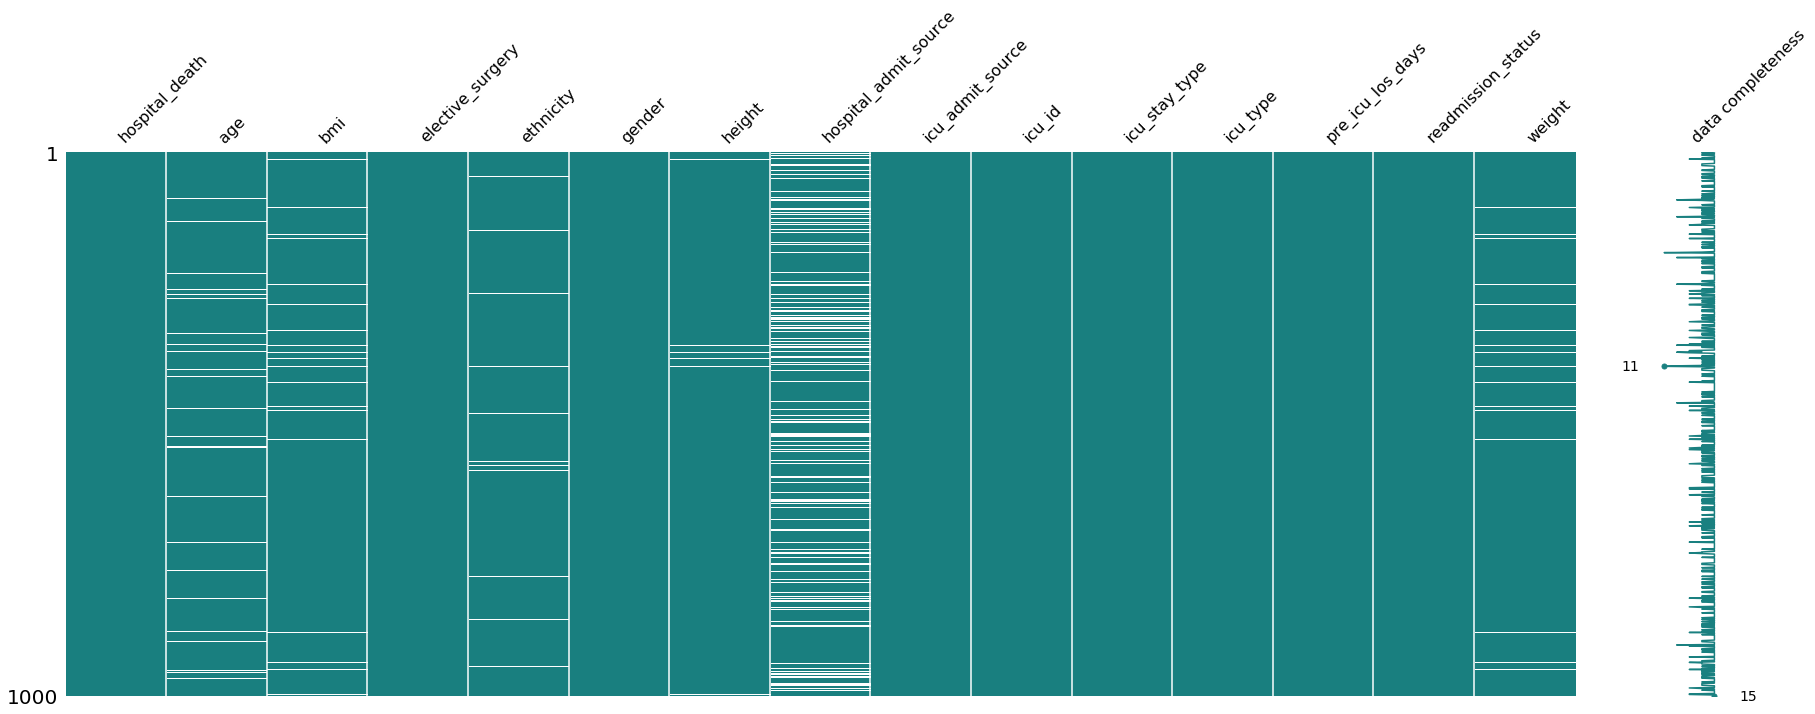

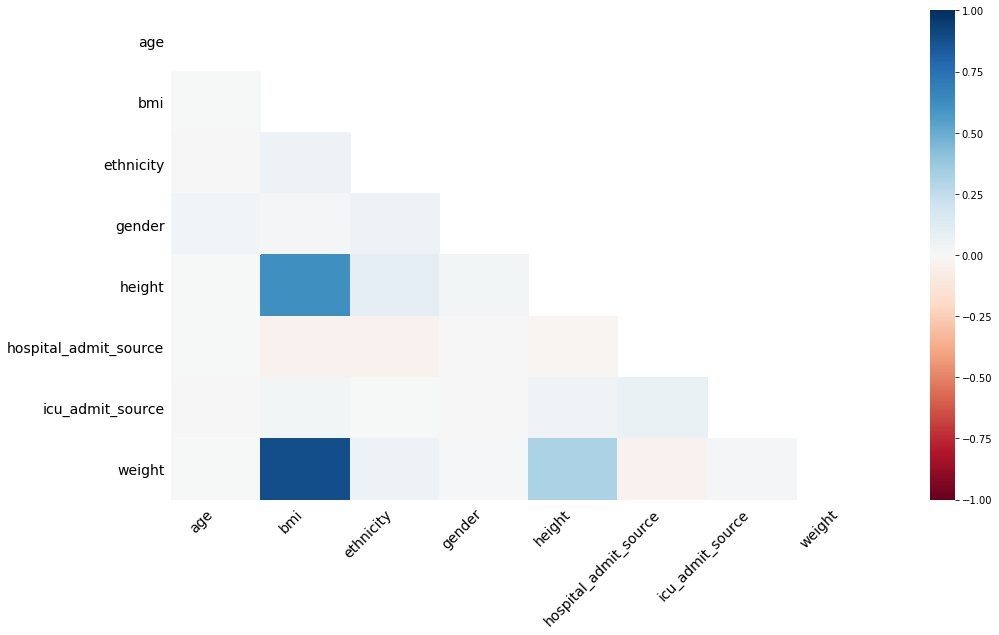

APACHE covariate


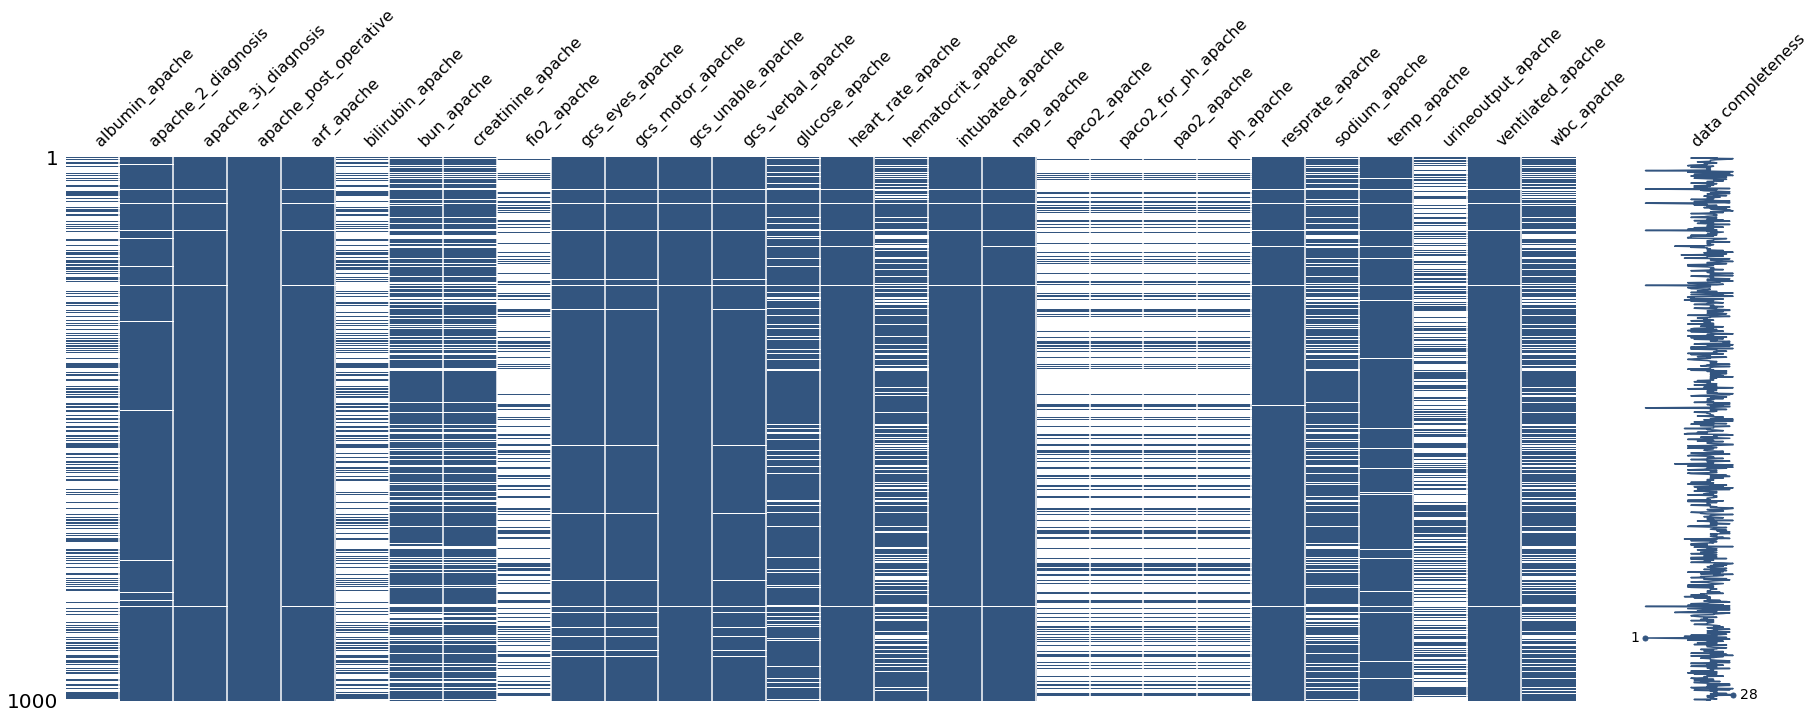

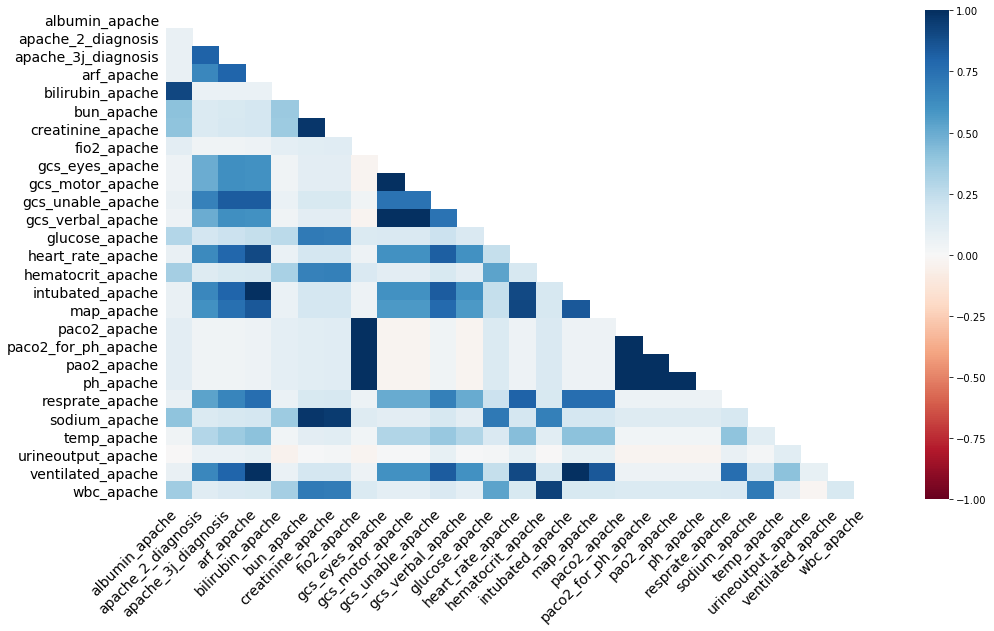

vitals


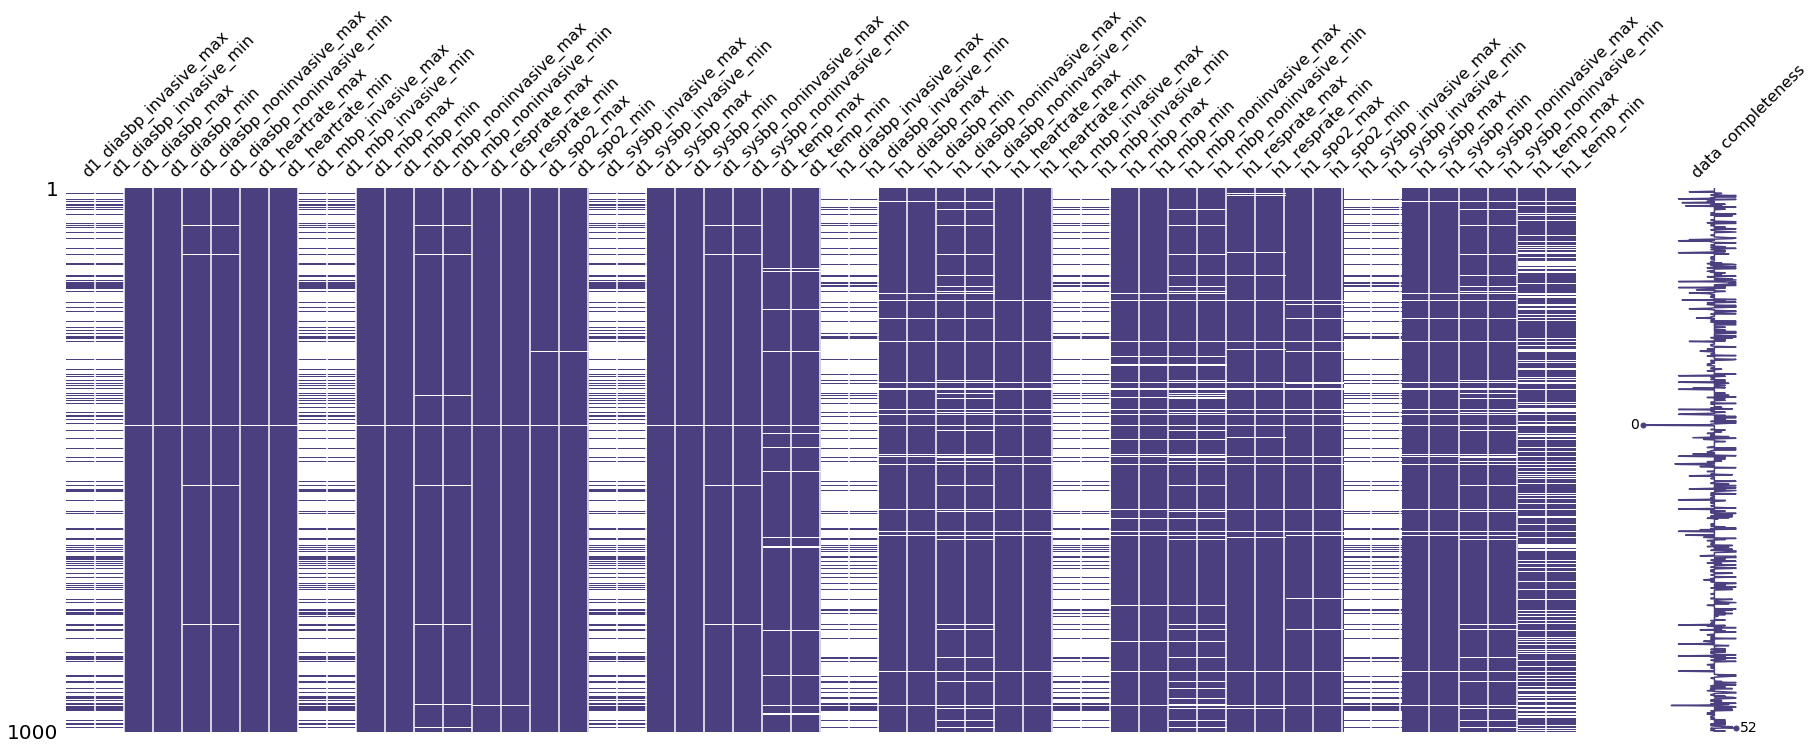

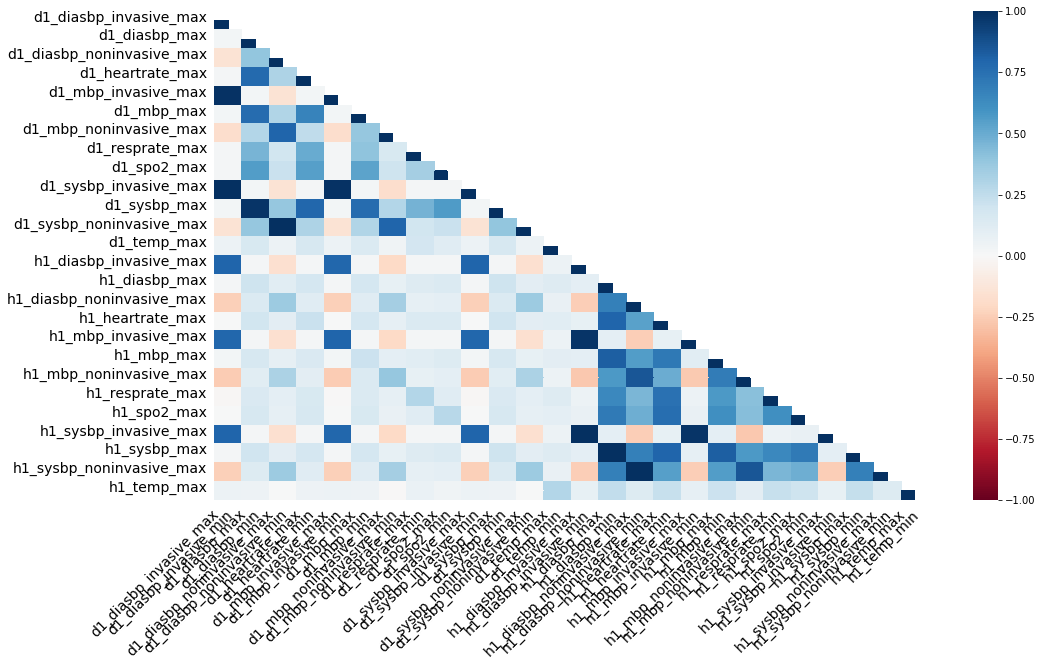

labs


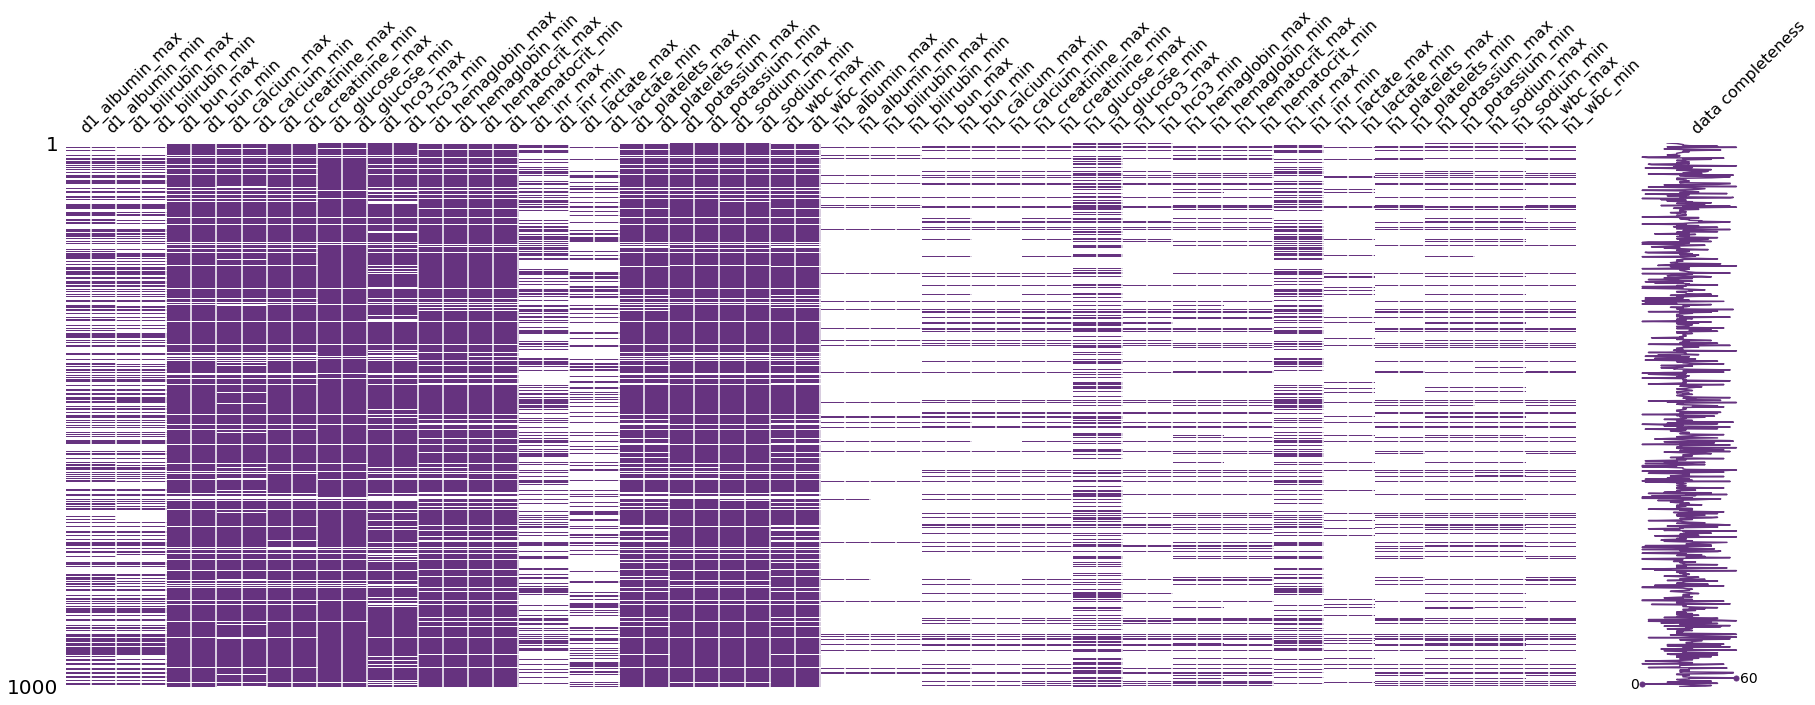

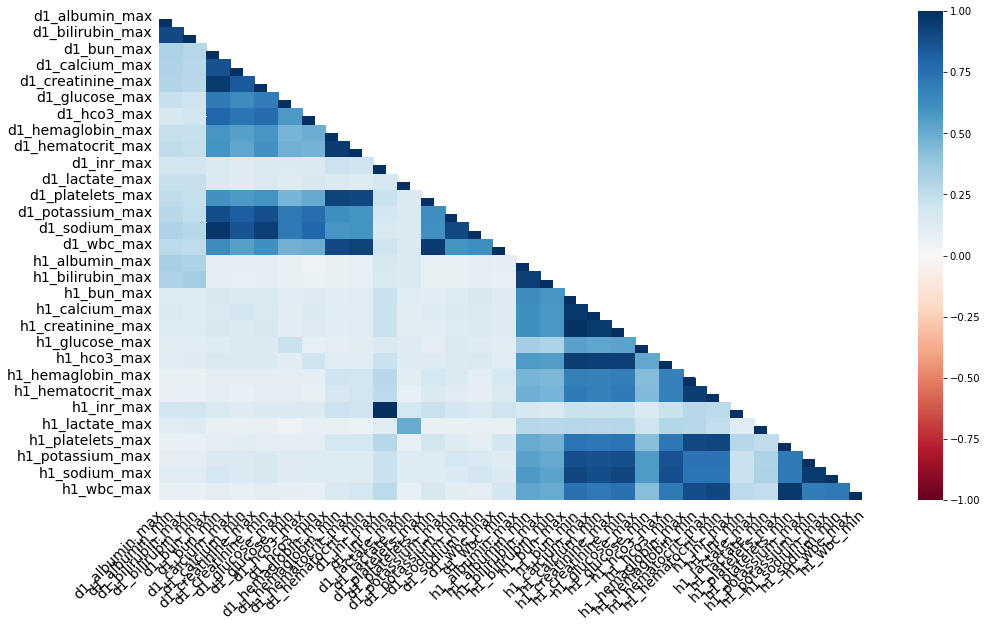

labs blood gas


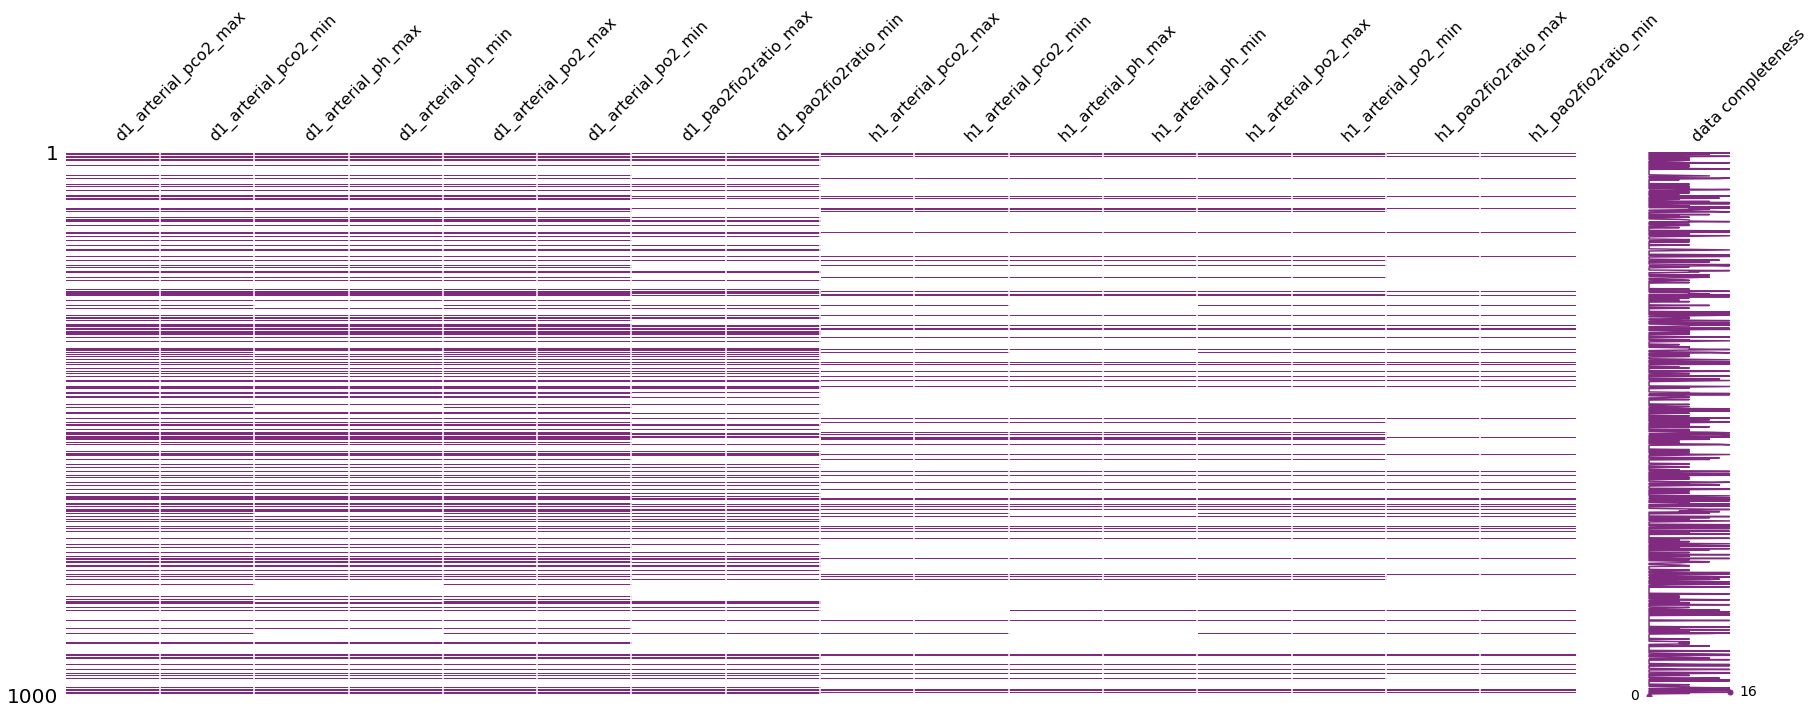

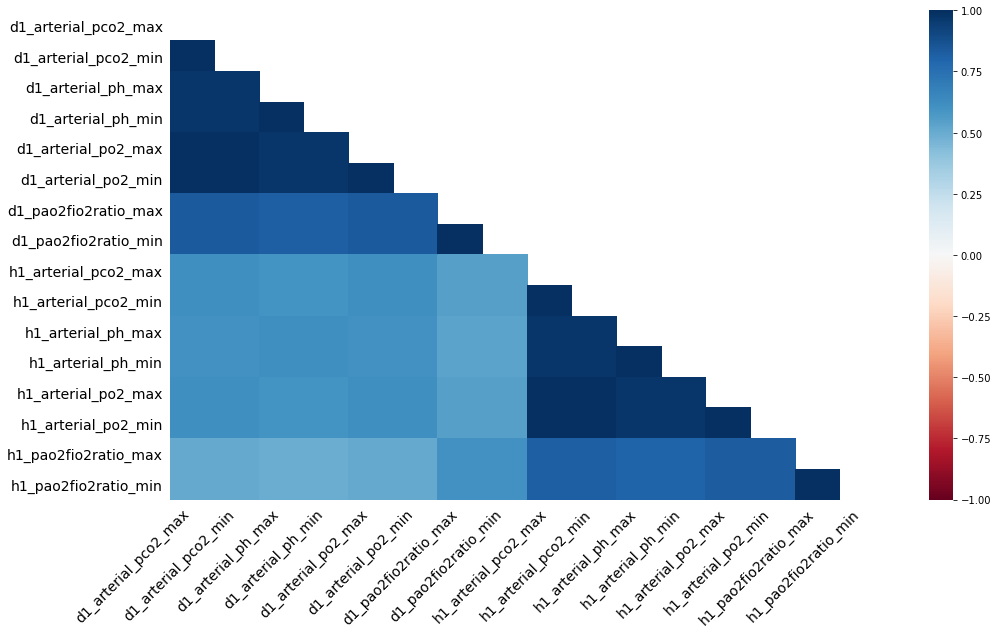

APACHE prediction


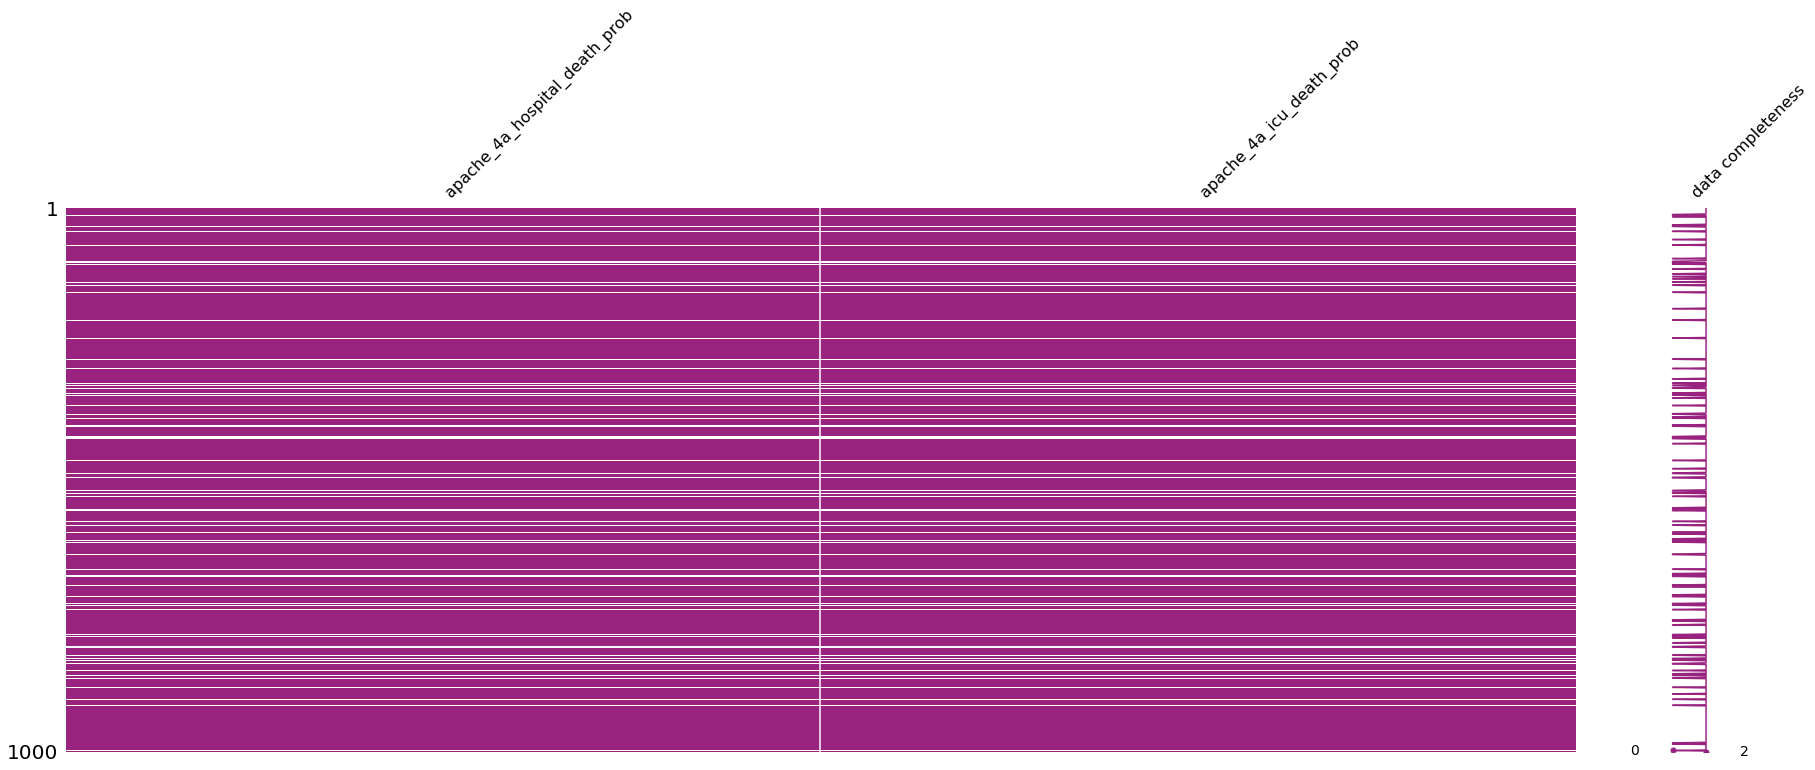

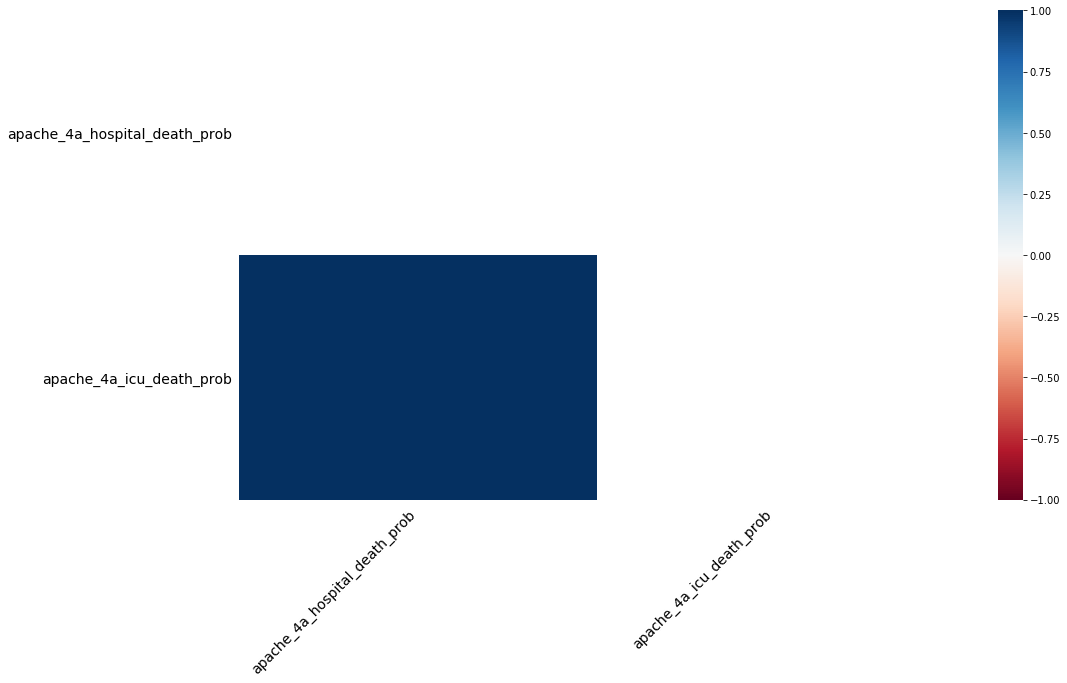

APACHE comorbidity


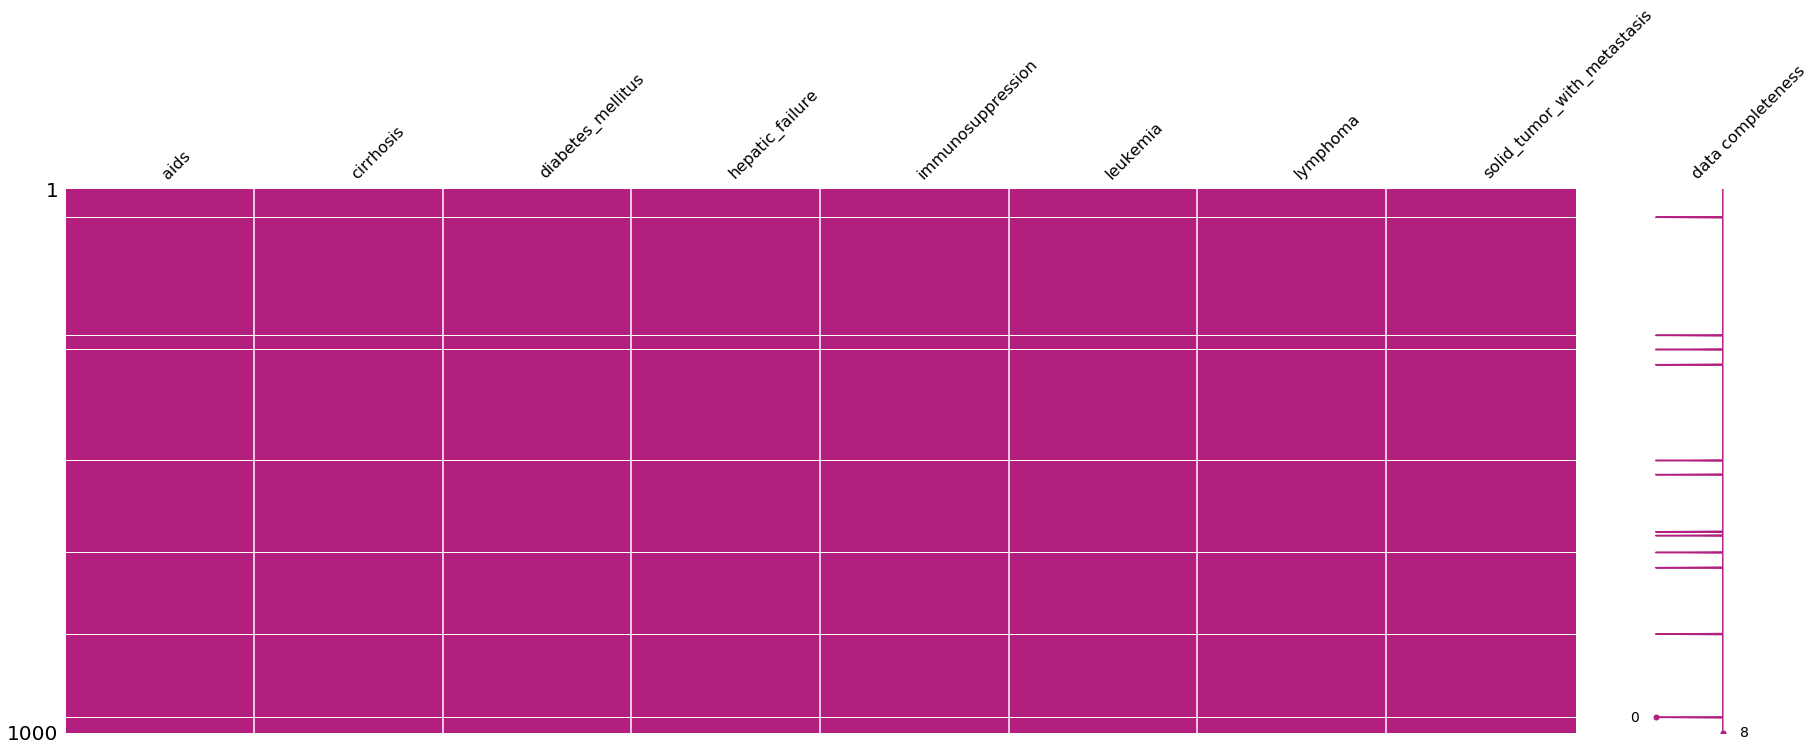

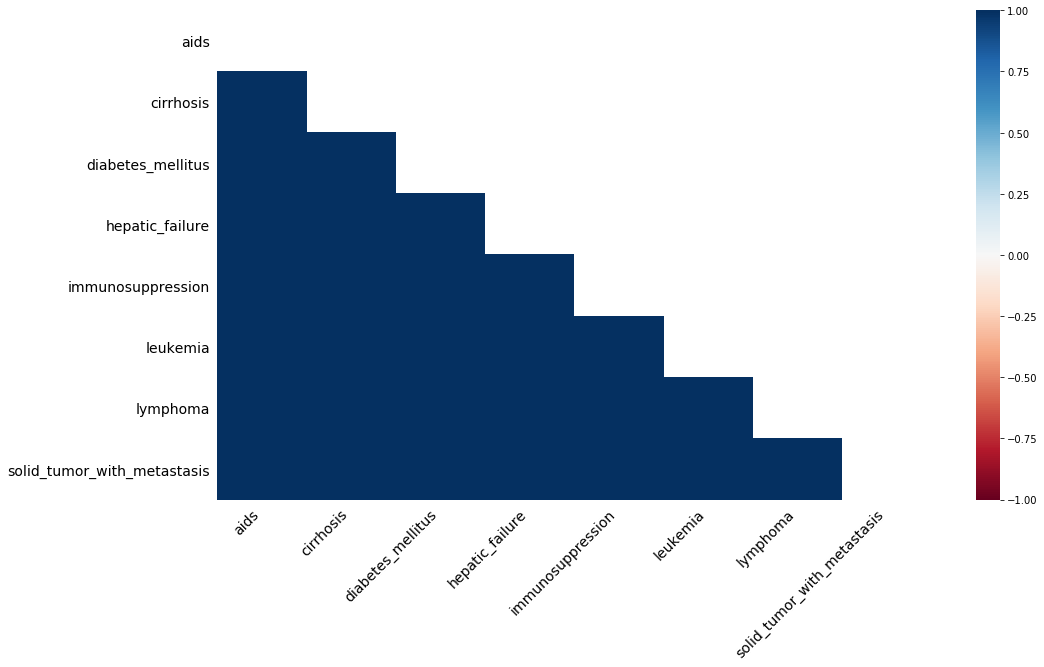

APACHE grouping


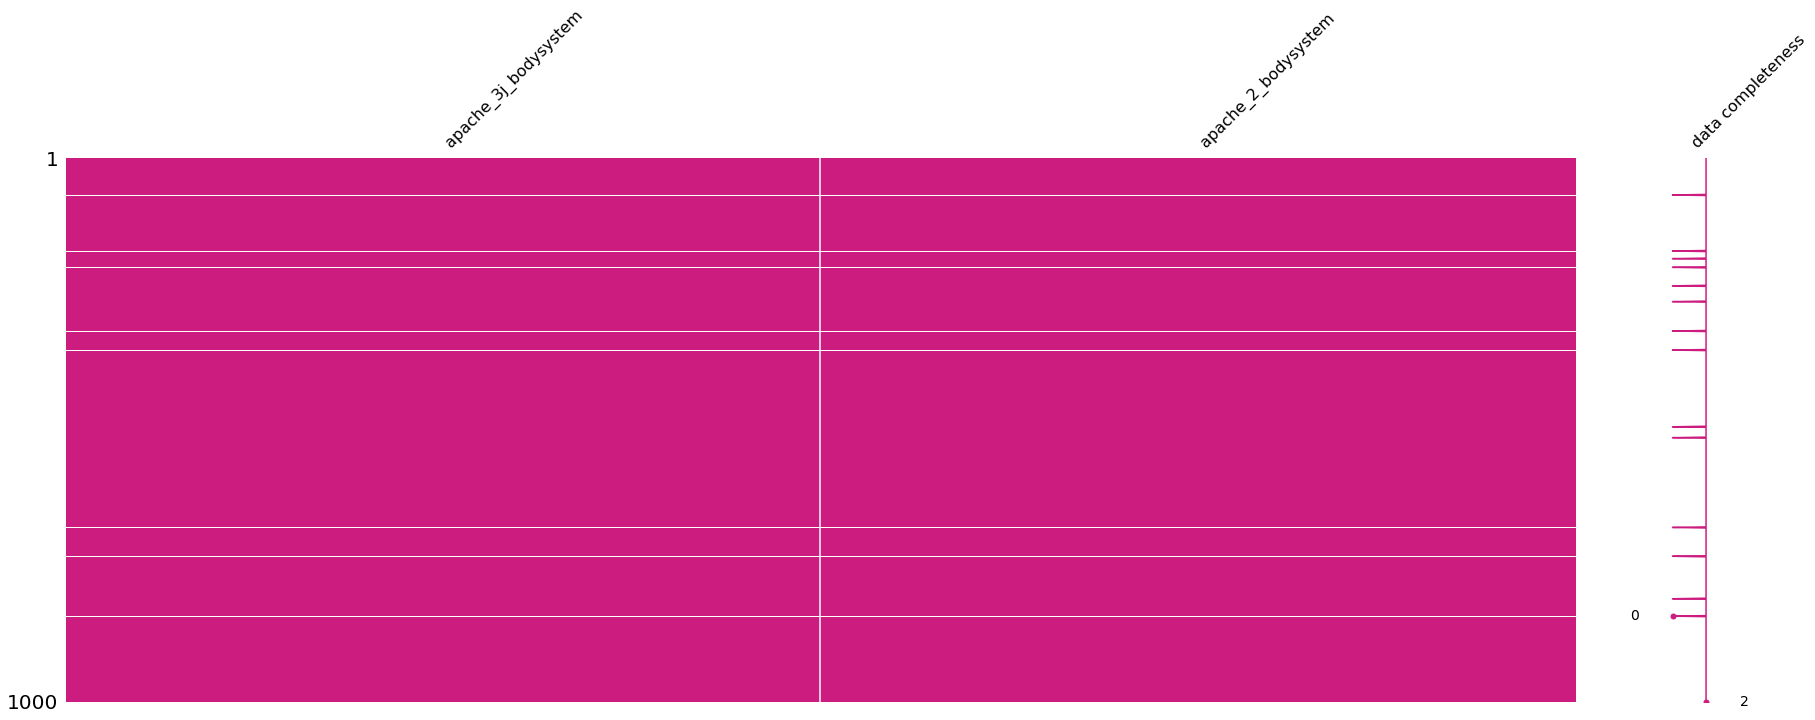

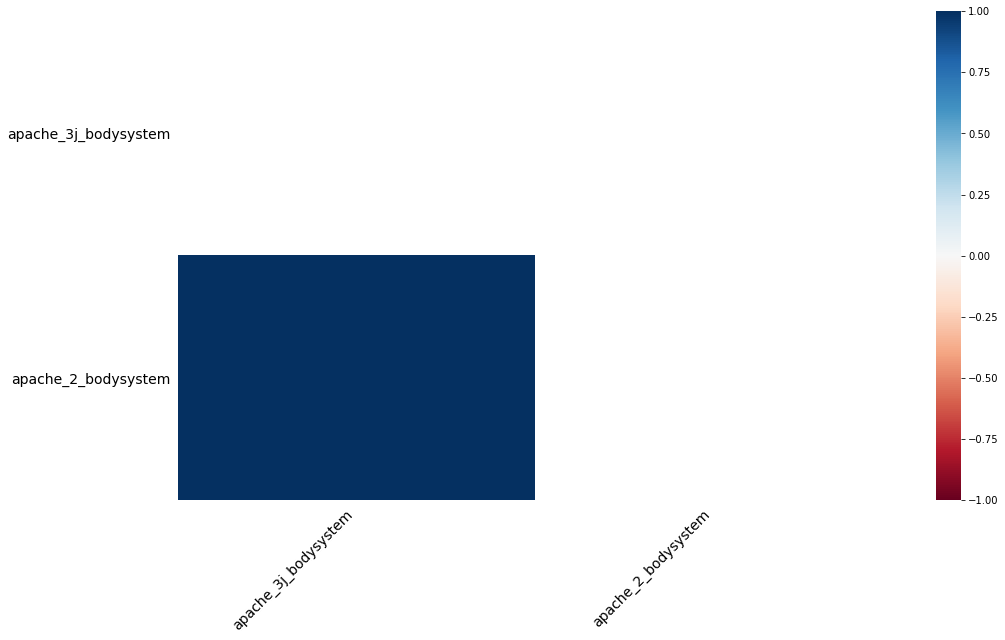

In [4]:
import missingno as msno
import matplotlib.pyplot as plt

for color, variable in enumerate(data_dict["Category"].unique()):
    if variable not in ["GOSSIS example prediction", "identifier"]:
        print(variable)
        column_list = data_dict[data_dict["Category"] == variable]["Variable Name"].values.tolist()
        column_list = [f for f in column_list if f in df.columns]
        if len(column_list) > 0:
            msno.matrix(
                df[column_list].sample(1000),
                figsize=(30, 10),
                labels=True,
                color=(color / 10, 1 / (color + 1), 0.5),
                fontsize=16,
            )
            msno.heatmap(
                df[column_list], figsize=(16, 9), labels=False, fontsize=14
            )
            plt.show()

# Preparation: Challenges Faced and How We Handled Them

## Null Values: A Different Beast in an Imbalanced Data Set
Since our target value (patient survivability) we're attempting to predict is imbalanced in our dataset, this affects our ability to handle nulls through blanket fixes. What we'll have to do is correlate the significance of the missing values against our target value to identify if the missing values are actually playing a role in patient survivability. 

In [5]:
import pandas as pd
from scipy import stats
# Set alpha value
alpha = 0.05

for col in df.columns:

    a, b = df[col], df["hospital_death"]

    observed = pd.crosstab(a, b) 
    chi2, p, degf, expected = stats.chi2_contingency(observed)

    if p < alpha:
        # Reject the null hypothesis
        print("({} and hospital_death) are  dependent of each other. (p = {})".format(col, p))
    else:
        # Failed to reject the null hypothesis
        print("({} and hospital_death) are  independent of each other. (p = {})".format(col, p))

(encounter_id and hospital_death) are  independent of each other. (p = 0.4984475106646044)
(hospital_id and hospital_death) are  dependent of each other. (p = 3.971188907548724e-148)
(hospital_death and hospital_death) are  dependent of each other. (p = 0.0)
(age and hospital_death) are  dependent of each other. (p = 4.3986226670688454e-204)
(bmi and hospital_death) are  independent of each other. (p = 0.10323036630688469)
(elective_surgery and hospital_death) are  dependent of each other. (p = 1.8111023373323387e-176)
(ethnicity and hospital_death) are  dependent of each other. (p = 0.0031164745025517304)
(gender and hospital_death) are  dependent of each other. (p = 0.03441709366041668)
(height and hospital_death) are  dependent of each other. (p = 0.0021710052871524873)
(hospital_admit_source and hospital_death) are  dependent of each other. (p = 1.2519350471326363e-197)
(icu_admit_source and hospital_death) are  dependent of each other. (p = 3.7031521455538844e-243)
(icu_id and hos

Applying all our data transformations:

In [6]:
df = src.wrangle.get_training_data()

In [7]:
print(f'Number of Columns: {df.shape[1]}, Number of rows: {df.shape[0]}')

Number of Columns: 185, Number of rows: 91688


> After fixing missing values and min-max issues, we don't have a significant loss in data points.

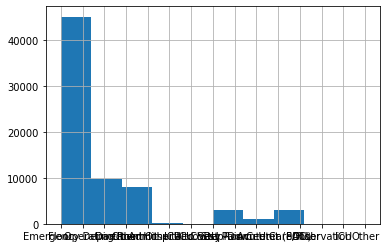

In [12]:
df.hospital_admit_source.hist()

In [18]:
from sklearn.impute import KNNImputer

In [21]:
kimp = KNNImputer(missing_value = np.nan)
X = df.drop(df.hospital_admit_source)
y = df.hospital_admit_source
KNNImputer.fit_transform(X, y)

KeyError: "['Floor' 'Floor' 'Emergency Department' ... 'Emergency Department'\n 'Emergency Department' nan] not found in axis"

In [8]:
df.isna().sum().sort_values(ascending=False)

hospital_admit_source            21406
apache_4a_icu_death_prob          7941
apache_4a_hospital_death_prob     7941
apache_2_bodysystem               1661
apache_3j_bodysystem              1661
                                 ...  
d1_platelets_min                     0
d1_platelets_max                     0
d1_lactate_min                       0
d1_lactate_max                       0
encounter_id                         0
Length: 185, dtype: int64

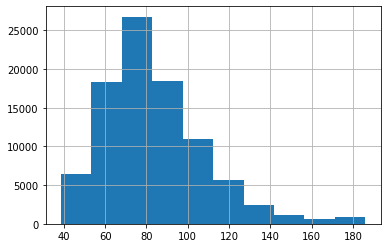

In [9]:
df.weight.hist()

# Exploration: Examining Which Factors are Affecting Patient Survival

## Are certain hospitals better at data collection, and does that have an impact on patient outcomes?

## Is there a link between hospital and death rate?

## Does the age of the patient have a significant impact on patient survivability?

## The gender of the patient and outcome?

# Feature Engineering: 'Bringing a Magnet to the Needle in a Haystack Problem'

# Modeling: Bringing it All Together

## Encoding the Data

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
l = ['ethnicity','gender','hospital_admit_source', 'icu_admit_source','icu_type', 'apache_3j_bodysystem',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

def encode(df, l):
    '''
    OneHot encodes the data in a column or columns
    '''
    encoder = OneHotEncoder(sparse = False)
    encoder.fit(df[l])
    m = encoder.transform(df[l])
    col_name= encoder.get_feature_names(l)
    df = pd.concat([df, pd.DataFrame(m, columns = col_name,index = df.index)], axis =1)
    df = df.drop(columns = l)
    return df

df = encode(df, l)

ValueError: Input contains NaN

## Splitting the Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(columns=['hospital_death'])

In [ ]:
y = df.hospital_death

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X, y)

# Conclusion: What We've Done and What's Next